In [12]:
import numpy as np
import pandas as pd
import time
from Frozen_Lake import FrozenLakeEnv
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (13, 7)

env = FrozenLakeEnv()

Если награда не зависит от $s'$:
$$
q(s,a) = R(s, a) + \gamma \sum_{s'} P(s'|s,a) v(s')
$$
Если награда зависит от $s'$:
$$
q(s,a) = \sum_{s'} P(s'|s,a) \Big( R(s,a,s') + \gamma v(s')\Big)
$$
Если награда не зависит от $s'$ - это частный случай того, когда награда зависит от $s'$:
$$
q(s,a) = \sum_{s'} P(s'|s,a) \Big( R(s,a) + \gamma v(s')\Big) = R(s,a) \sum_{s'} P(s'|s,a) + \gamma \sum_{s'} P(s'|s,a) v(s')
 = R(s, a) + \gamma \sum_{s'} P(s'|s,a) v(s')
$$



In [2]:
def value_iteration(v_values, gamma):
    next_v_values = {}
    
    for state in env.get_all_states():
        action_rewards = {}
        for action in env.get_possible_actions(state):
            action_rewards[action] = 0
            for next_state in env.get_next_states(state, action):
                action_rewards[action] += env.get_transition_prob(state, action, next_state) * env.get_reward(state, action, next_state)
                action_rewards[action] += gamma * env.get_transition_prob(state, action, next_state) * v_values[next_state]
        if len(action_rewards) > 0:
            next_v_values[state] = action_rewards[max(action_rewards, key=action_rewards.get, default=None)]
        else:
            next_v_values[state] = 0
    return next_v_values

                
def get_q_values(v_values, gamma):
    q_values = {}
    for state in env.get_all_states():
        q_values[state] = {}
        for action in env.get_possible_actions(state):
            q_values[state][action] = 0
            for next_state in env.get_next_states(state, action):
                q_values[state][action] += env.get_transition_prob(state, action, next_state) * env.get_reward(state, action, next_state)
                q_values[state][action] += gamma * env.get_transition_prob(state, action, next_state) * v_values[next_state]
    return q_values

def init_policy():
    policy = {}
    for state in env.get_all_states():
        policy[state] = {}
        for action in env.get_possible_actions(state):
            policy[state][action] = 1 / len(env.get_possible_actions(state))
    return policy

def init_v_values():
    v_values = {}
    for state in env.get_all_states():
        v_values[state] = 0
    return v_values

def policy_evaluation_step(v_values, policy, gamma):
    q_values = get_q_values(v_values, gamma)
    new_v_values = init_v_values()
    for state in env.get_all_states():
        new_v_values[state] = 0
        for action in env.get_possible_actions(state):
            new_v_values[state] += policy[state][action] * q_values[state][action]
    return new_v_values
    
def policy_evaluation(policy, gamma, eval_iter_n):
    v_values = init_v_values()
    for _ in range(eval_iter_n):
        v_values = policy_evaluation_step(v_values, policy, gamma)
    q_values = get_q_values(v_values, gamma)
    return q_values

def policy_evaluation_value(gamma):
    v_values = init_v_values()
    v_values = value_iteration(v_values, gamma)
    q_values = get_q_values(v_values, gamma)
    return q_values
    
def policy_improvement(q_values):
    policy = {}
    for state in env.get_all_states():
        policy[state] = {}
        argmax_action = None
        max_q_value = float('-inf')
        for action in env.get_possible_actions(state): 
            policy[state][action] = 0
            if q_values[state][action] > max_q_value:
                argmax_action = action
                max_q_value = q_values[state][action]
        policy[state][argmax_action] = 1
    return policy

def value_evaluation(gamma, eval_iter_n):
    v_values = init_v_values()
    for _ in range(eval_iter_n):
        v_values = value_iteration(v_values, gamma)
    q_values = get_q_values(v_values, gamma)
    return q_values

In [17]:
policy_iteration_rewards = {}

In [18]:
for gamma in [0.99, 0.999, 0.9999]:
    print("Gamma: ", gamma)
    policy_iteration_rewards[gamma] = []

    for val in np.arange(50, 300, 20):
        
        env.reset()
        iter_n = val
        eval_iter_n = val
        
        policy = init_policy()
        for _ in range(iter_n):
            q_values = policy_evaluation(policy, gamma, eval_iter_n)
            policy = policy_improvement(q_values)
            
        total_rewards = []

        for _ in range(1000):
            total_reward = 0
            state = env.reset()
            for _ in range(1000):
                action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
                state, reward, done, _ = env.step(action)
                total_reward += reward
                
                if done:
                    break
            
            total_rewards.append(total_reward)

        policy_iteration_rewards[gamma].append(np.mean(total_rewards))
        
        print(iter_n, eval_iter_n, np.mean(total_rewards))

Gamma:  0.99
50 50 0.854
70 70 0.85
90 90 0.87
110 110 0.854
130 130 0.863
150 150 0.85
170 170 0.85
190 190 0.868
210 210 0.852
230 230 0.86
250 250 0.863
270 270 0.872
290 290 0.865
Gamma:  0.999
50 50 0.855
70 70 0.857
90 90 0.877
110 110 0.965
130 130 0.861
150 150 0.867
170 170 0.965
190 190 0.852
210 210 0.857
230 230 0.966
250 250 0.868
270 270 0.854
290 290 0.844
Gamma:  0.9999
50 50 0.88
70 70 0.859
90 90 0.874
110 110 0.972
130 130 0.856
150 150 0.87
170 170 0.879
190 190 0.857
210 210 0.872
230 230 0.845
250 250 0.874
270 270 0.857
290 290 0.878


In [5]:
values_iteration_rewards = {}

In [6]:
def value_evaluation(gamma, iter_n):
    v_values = init_v_values()
    for _ in range(iter_n):
        v_values = value_iteration(v_values, gamma)
    q_values = get_q_values(v_values, gamma)
    return q_values

for gamma in [0.99, 0.999, 0.9999]:
    print("Gamma: ", gamma)
    values_iteration_rewards[gamma] = []

    for val in np.arange(50, 300, 20):
        
        env.reset()
        iter_n = val ** 2
        
        policy = init_policy()
        q_values = value_evaluation(gamma, iter_n)
        policy = policy_improvement(q_values)
            
        total_rewards = []

        for _ in range(1000):
            total_reward = 0
            state = env.reset()
            for _ in range(1000):
                action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
                state, reward, done, _ = env.step(action)
                total_reward += reward
                
                if done:
                    break
            
            total_rewards.append(total_reward)

        values_iteration_rewards[gamma].append(np.mean(total_rewards))
        print(iter_n, np.mean(total_rewards))

Gamma:  0.99
2500 0.859
4900 0.863
8100 0.85
12100 0.887
16900 0.872
22500 0.867
28900 0.841
36100 0.848
44100 0.862
52900 0.868
62500 0.871
72900 0.871
84100 0.843
Gamma:  0.999
2500 0.964
4900 0.977
8100 0.967
12100 0.961
16900 0.971
22500 0.969
28900 0.974
36100 0.979
44100 0.961
52900 0.97
62500 0.969
72900 0.963
84100 0.967
Gamma:  0.9999
2500 0.994
4900 0.994
8100 0.99
12100 0.989
16900 0.988
22500 0.996
28900 0.996
36100 0.995
44100 0.993
52900 0.992
62500 0.996
72900 0.996
84100 0.991


Text(0.5, 1.0, 'Policy iteration vs Value Iteriation')

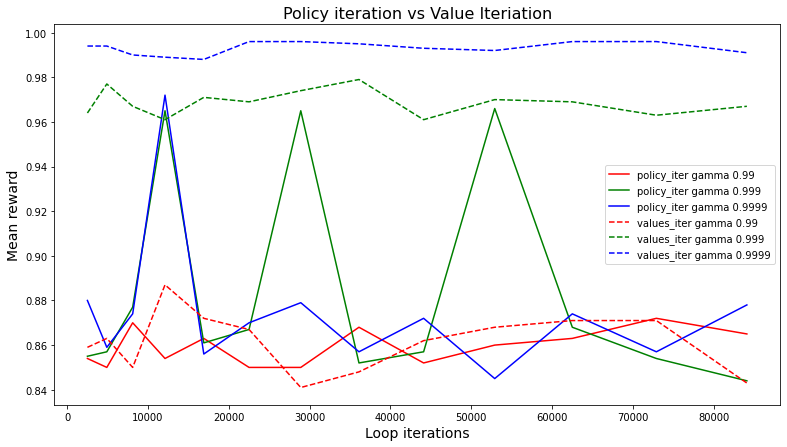

In [19]:
x_vals = [val**2 for val in np.arange(50, 300, 20)]

for key, color in zip(policy_iteration_rewards.keys(), ['r', 'g', 'b']):
    plt.plot(x_vals, policy_iteration_rewards[key], label = f"policy_iter gamma {key}", c = color)
for key, color in zip(values_iteration_rewards.keys(), ['r', 'g', 'b']):
    plt.plot(x_vals, values_iteration_rewards[key], '--', label = f"values_iter gamma {key}", c = color)
plt.legend(loc = 'best')
plt.xlabel("Loop iterations", fontsize = 14)
plt.ylabel("Mean reward", fontsize = 14)
plt.title("Policy iteration vs Value Iteriation", fontsize = 16)